In [ ]:
# Written by:Kaustubh Dwivedi
#                      22117066
#                      Kaustubh_d@me.iitr.ac.in
#                      Mechanical engineering IIT roorkee

# Import necessary libraries
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from skimage import io
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2


from google.colab import drive
drive.mount('/content/drive')
# google_drive_file_url = 'https://drive.google.com/uc?id=<YOUR_FILE_ID>'

# # Download the zip file from Google Drive
# gdown.download(google_drive_file_url, 'train.zip', quiet=False)

Mounted at /content/drive


In [ ]:
# Helper function to display images using OpenCV
def cv2disp(name, image, xpos, ypos):
    # Normalize the image for display
    image = image / (np.max(image) + 1e-15)
    cv2.imshow(name, image)
    cv2.moveWindow(name, xpos, ypos)


In [ ]:
# Extract images from Train.zip (assuming it contains 'low' and 'high' folders)
# with zipfile.ZipFile('Train.zip', 'r') as zip_ref:
#     zip_ref.extractall('Train')'

base_dir = '/content/drive/My Drive/Train'
low_dir = os.path.join(base_dir, 'low')
high_dir = os.path.join(base_dir, 'high')

# Define paths to 'low' and 'high' folders
# low_dir = 'Train/low'
# high_dir = 'Train/high'

# Filter out files that are not .png or .jpg in both 'low' and 'high' folders
low_files = [os.path.join(low_dir, f) for f in os.listdir(low_dir) if f.endswith('.png') or f.endswith('.jpg')]
high_files = [os.path.join(high_dir, f) for f in os.listdir(high_dir) if f.endswith('.png') or f.endswith('.jpg')]

# Ensure images have the same order in both 'low' and 'high' folders
low_files.sort()
high_files.sort()

# Check if the number of images in 'low' and 'high' folders match
assert len(low_files) == len(high_files), "Number of images in 'low' and 'high' folders do not match"

# Print total number of image pairs found
print(f"Total image pairs found: {len(low_files)}")


Total image pairs found: 485


In [ ]:
# # Custom dataset class for loading images
# class ImageDataset(Dataset):
#     def __init__(self, low_files, high_files):
#         self.low_files = low_files
#         self.high_files = high_files

#     def __len__(self):
#         return len(self.low_files)

#     def __getitem__(self, idx):
#         # Read images using skimage
#         low_img = io.imread(self.low_files[idx]).astype(np.float32) / 255.0
#         high_img = io.imread(self.high_files[idx]).astype(np.float32) / 255.0

#         # Generate noisy version of low-quality image using Poisson noise
#         noisy_low_img = np.random.poisson(low_img * 255) / 255.0

#         # Convert images to PyTorch tensors and add channel dimension
#         return torch.tensor(noisy_low_img).unsqueeze(0), torch.tensor(high_img).unsqueeze(0)

# # Create dataset instance
# dataset = ImageDataset(low_files, high_files)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, low_files, high_files):
        self.low_files = low_files
        self.high_files = high_files

    def __len__(self):
        return len(self.low_files)

    def __getitem__(self, idx):
        # Read images using skimage
        low_img = io.imread(self.low_files[idx]).astype(np.float32) / 255.0
        high_img = io.imread(self.high_files[idx]).astype(np.float32) / 255.0

        # Ensure images are in the correct color channel format (H, W, C)
        if low_img.shape[-1] != 3:
            low_img = np.transpose(low_img, (1, 2, 0))
        if high_img.shape[-1] != 3:
            high_img = np.transpose(high_img, (1, 2, 0))

        # Generate noisy version of low-quality image using Poisson noise
        noisy_low_img = np.random.poisson(low_img * 255) / 255.0

        # Convert images to PyTorch tensors and add channel dimension
        # Explicitly cast to float32 and remove extra dimension if present
        return torch.tensor(noisy_low_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0), \
               torch.tensor(high_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    # The tensors returned by __getitem__ are now explicitly float32 and have the expected shape

dataset = ImageDataset(low_files, high_files)

In [ ]:
# Define sizes for training, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)


In [ ]:
# Define U-Net architecture for image denoising
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            self.conv_block(1, 64),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512)
        )
        # Define decoder layers
        self.decoder = nn.Sequential(
            self.up_conv_block(512, 256),
            self.up_conv_block(256, 128),
            self.up_conv_block(128, 64),
            self.up_conv_block(64, 1)
        )

    def conv_block(self, in_channels, out_channels):
        # Convolutional block
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def up_conv_block(self, in_channels, out_channels):
        # Up-sampling block
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Forward pass through U-Net
        e1 = self.encoder[0](x)
        e2 = self.encoder[1](e1)
        e3 = self.encoder[2](e2)
        e4 = self.encoder[3](e3)

        d4 = self.decoder[0](e4)
        d3 = self.decoder[1](d4 + e3)  # Skip connection
        d2 = self.decoder[2](d3 + e2)  # Skip connection
        d1 = self.decoder[3](d2 + e1)  # Skip connection
        return d1

# Initialize the U-Net model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)

# Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)


In [ ]:
# Training loop with validation and intermediate results
for epoch in range(100):
    unet.train()  # Set the model to training mode
    train_loss = 0
    for img_lq, img_hq in train_loader:
        img_lq, img_hq = img_lq.to(device), img_hq.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output = unet(img_lq)  # Forward pass
        loss = loss_function(output, img_hq)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item()  # Accumulate training loss

        # Optionally, display intermediate results every 100 batches
        if len(train_loader) % 100 == 0:
            output = output.cpu().numpy().squeeze()
            img_lq = img_lq.cpu().numpy().squeeze()
            img_hq = img_hq.cpu().numpy().squeeze()

            # Display or save intermediate results (example using OpenCV)
            cv2disp('Output after CNN', output, nxd*3, nxd+30)
            cv2disp('Low Quality', img_lq, nxd, 0)
            cv2disp('High Quality', img_hq, 0, 0)
            cv2.waitKey(1)  # Ensure OpenCV display updates

    scheduler.step()  # Adjust learning rate

    # Validation step every 100 epochs
    if epoch % 100 == 0:
        val_loss = 0
        unet.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for img_lq, img_hq in val_loader:
                img_lq, img_hq = img_lq.to(device), img_hq.to(device)
                output = unet(img_lq)  # Forward pass
                loss = loss_function(output, img_hq)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss

        print(f"Epoch {epoch}, Training Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

        # Display or


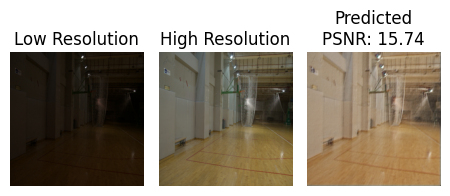


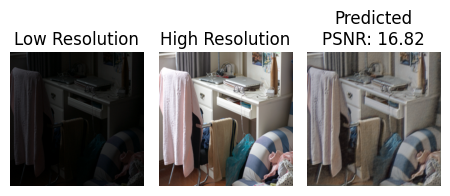

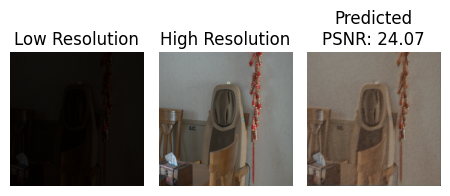

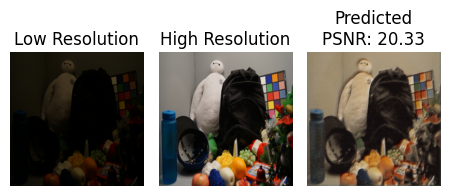

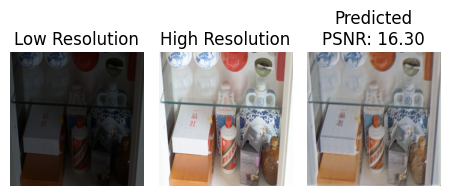

In [ ]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinity if images are identical
    max_pixel = 1.0  # Assuming pixel values are normalized to [0, 1]
    psnr_val = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_val


avg psnr
18.652


In [ ]:
# Evaluate on test set and calculate PSNR
unet.eval()  # Set the model to evaluation mode
test_psnr = 0
with torch.no_grad():
    for img_lq, img_hq in test_loader:
        img_lq, img_hq = img_lq.to(device), img_hq.to(device)
        output = unet(img_lq)  # Forward pass
        output = output.cpu().numpy().squeeze()
        img_hq = img_hq.cpu().numpy().squeeze()
        psnr_val = calculate_psnr(img_hq, output)  # Calculate PSNR for each image
        test_psnr += psnr_val  # Accumulate PSNR values for all images

test_psnr /= len(test_loader)  # Average PSNR over all test images
print(f"Average PSNR on test set: {test_psnr:.2f} dB")
